In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import numpy as np
import cv2
import glob

from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from scipy.ndimage.measurements import label
%matplotlib inline

In [2]:
cars = glob.glob('vehicles/*/*.jpg')
print(len(cars))

6941


In [3]:
non_cars = glob.glob('non-vehicles/*/*.jpg')
print(len(non_cars))

8968


In [4]:
def plot_image_set(images, titles, image_type=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(images[0], cmap=image_type)
    ax1.set_title(titles[0], fontsize=30)
    ax2.imshow(images[1], cmap=image_type)
    ax2.set_title(titles[1], fontsize=30)

In [5]:
params = dict()
params['nbins'] = 48
params['bins_range'] = (0, 256)
params['resize_image_size'] = (16, 16)
params['orient'] = 8
params['pixels_per_cell'] = 8
params['cells_per_block'] = 2

In [6]:
def color_hist(image, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

In [7]:
def bin_spatial(image, size=(32, 32)):
    features = cv2.resize(image, size).ravel()
    return features

In [8]:
def get_hog_features(image, orient, pix_per_cell, cell_per_block):
    hog_features = []
    for color_channel in range(image.shape[2]):
        channel_features = hog(image[:,:,color_channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                           visualise=False, feature_vector=True)
        hog_features.append(channel_features)
    hog_features = np.ravel(hog_features)    
    return hog_features

In [9]:
def extract_features(images, params):
    features = []
    for img_path in images:
        image = mpimg.imread(img_path)
        spatial_features = bin_spatial(image, size=params['resize_image_size'])
        hist_features = color_hist(image, nbins=params['nbins'], bins_range=params['bins_range'])
        hog_features = get_hog_features(image, params['orient'], params['pixels_per_cell'], params['cells_per_block'])
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
    return features

In [10]:
def extra_single_features(image, params):
    spatial_features = bin_spatial(image, size=params['resize_image_size'])
    hist_features = color_hist(image, nbins=params['nbins'], bins_range=params['bins_range'])
    hog_features = get_hog_features(image, params['orient'], params['pixels_per_cell'], params['cells_per_block'])
    return np.concatenate((spatial_features, hist_features,hog_features))

In [11]:
car_features = extract_features(cars, params)

In [12]:
non_car_features = extract_features(non_cars, params)

In [13]:
def create_train_test_set(car_features, non_car_features):
    X = np.vstack((np.array(car_features), np.array(non_car_features))).astype(np.float64)                        
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    Y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))
    X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, Y, test_size=0.2, random_state=1234)
    
    return X_train, Y_train, X_test, Y_test, X_scaler

In [14]:
X_train, Y_train, X_test, Y_test, X_scaler = create_train_test_set(car_features, non_car_features)

In [15]:
def train_test_svm(X_train, Y_train, X_test, Y_test):
    svc = SVC(C=1.0, probability=True)
    svc.fit(X_train, Y_train)
    
    print("Accuracy of classifier - {:.4f}".format(svc.score(X_test, Y_test)))
    return svc

In [16]:
clf = train_test_svm(X_train, Y_train, X_test, Y_test)

Accuracy of classifier - 0.9953


In [17]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy
    
    
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    
    window_list = []
    
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    
    return window_list

In [18]:
def search_windows(img, windows, clf, scaler, params):
    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        features = extra_single_features(test_img, params)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        if prediction > 0.5:
            on_windows.append(window)
    return on_windows

In [19]:
all_test_images = glob.glob('test_images/*')

In [20]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap
    
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [21]:
def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_w, bbox_h = abs(bbox[1][0] - bbox[0][0]), abs(bbox[1][1] - bbox[0][1])
        if bbox[0][1] <= 300:
            continue
        if bbox[0][1] >= 600:
            continue
        if bbox[0][0] >= 1220:
            continue
        bbox_area = bbox_w * bbox_h
        if bbox_area <= 2500:
            continue
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

In [22]:
def image_pipeline(image, static_images=False):
    global prev_frame_heat
    image_copy = np.copy(image)
    
    windows1 = slide_window(image, x_start_stop=[640, 1280], y_start_stop=[300, 450], 
                xy_window=(64, 64), xy_overlap=(0.6, 0.6))
    
    windows2 = slide_window(image, x_start_stop=[640, 1280], y_start_stop=[300, 500], 
                xy_window=(96, 96), xy_overlap=(0.8, 0.8))
    
    windows3 = slide_window(image, x_start_stop=[640, 1280], y_start_stop=[400, 550], 
                xy_window=(128, 128), xy_overlap=(0.85, 0.85))

    windows = windows1 + windows2 + windows3 

    hot_windows = search_windows(image, windows, clf, X_scaler, params)                  

    window_img = draw_boxes(image_copy, hot_windows, color=(0, 0, 255), thick=6)                    
    
    heat_image = np.zeros_like(image[:,:,0]).astype(np.float)

    add_heat(heat_image, hot_windows)
    
    '''Apply Simple Exponential Filter'''
    if not static_images:
        if prev_frame_heat == None:
            prev_frame_heat = heat_image
        else:
            heat_image = (prev_frame_heat * 0.2) + (heat_image * 0.8)
            prev_frame_heat = heat_image
        
    heatmaps = apply_threshold(heat_image, 2)
    labels = label(heatmaps)
    
    final_image = draw_labeled_bboxes(np.copy(image), labels)
    return final_image

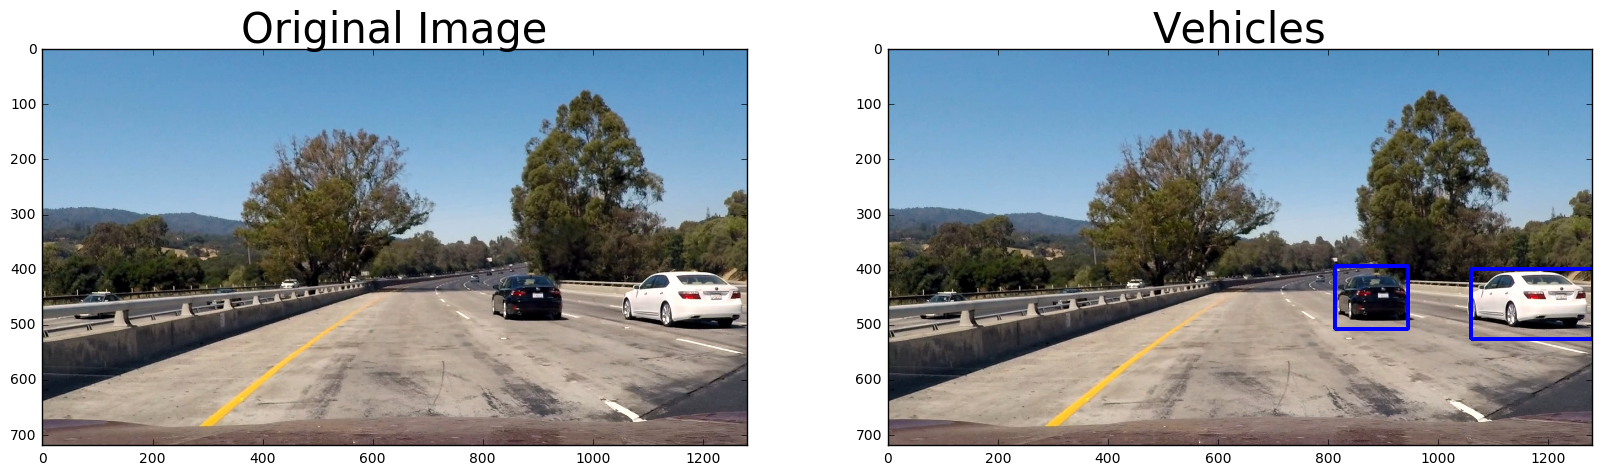

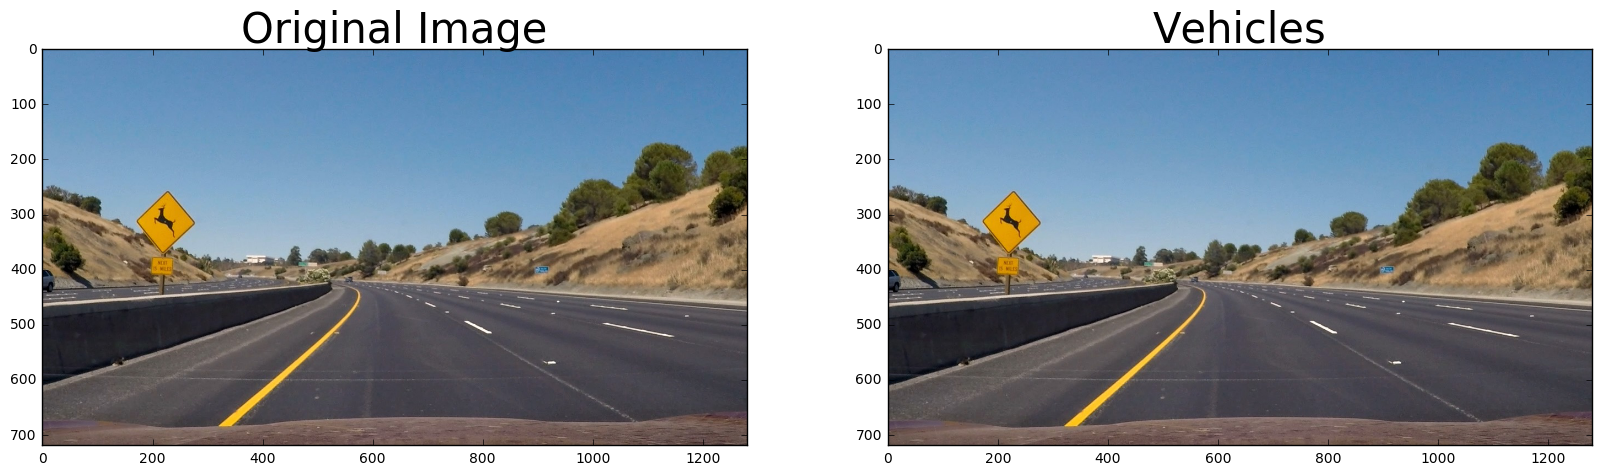

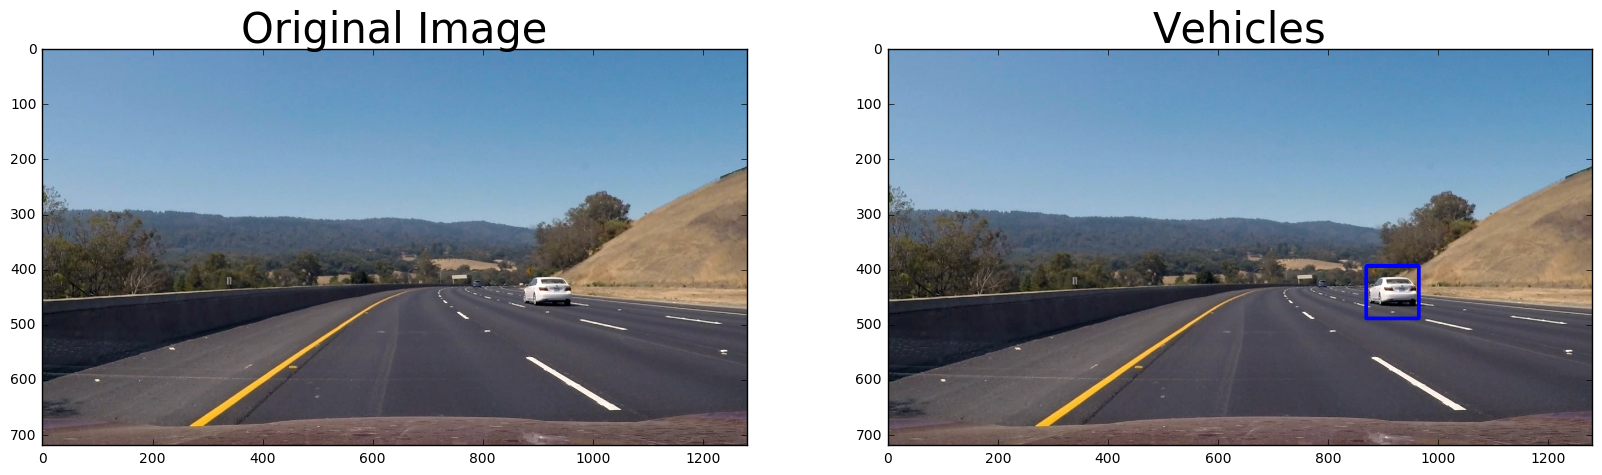

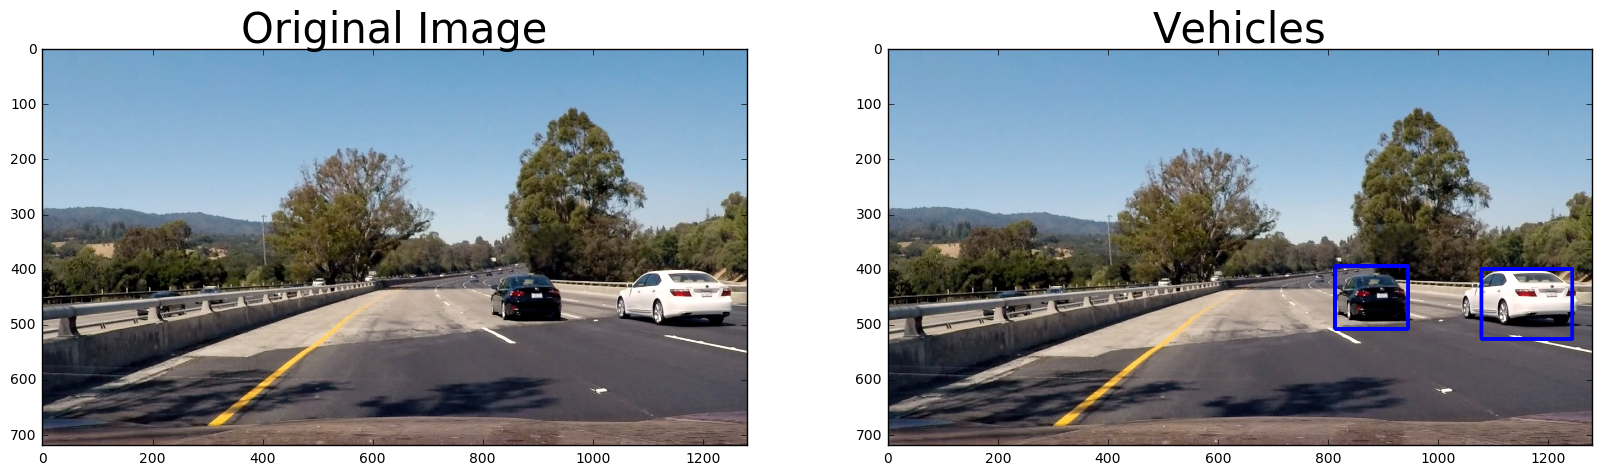

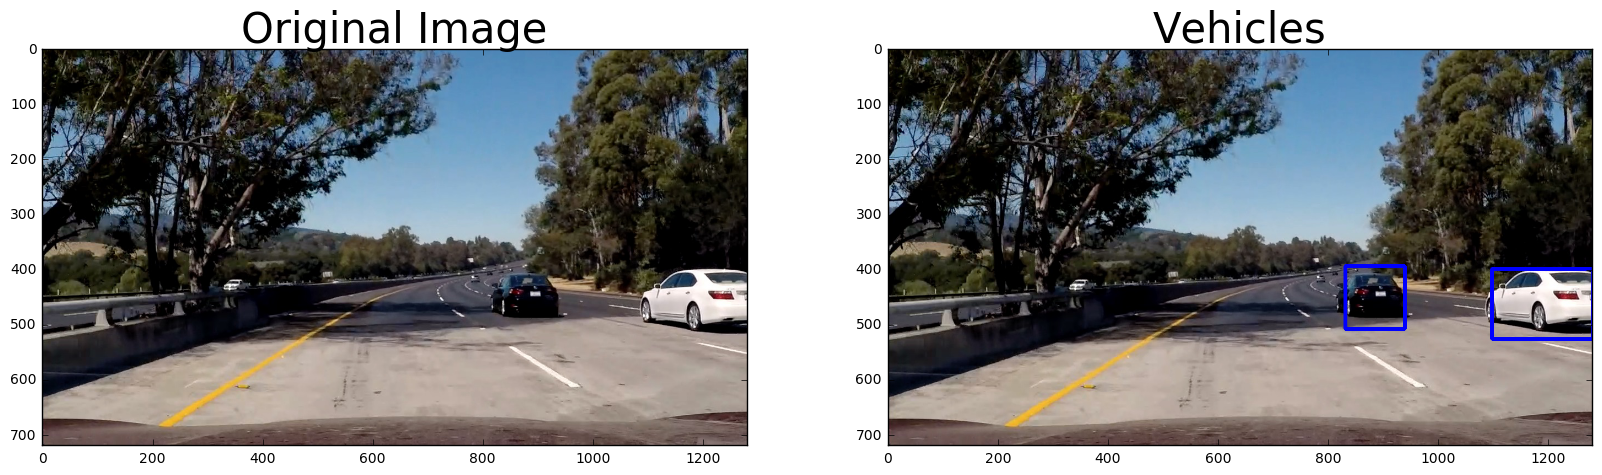

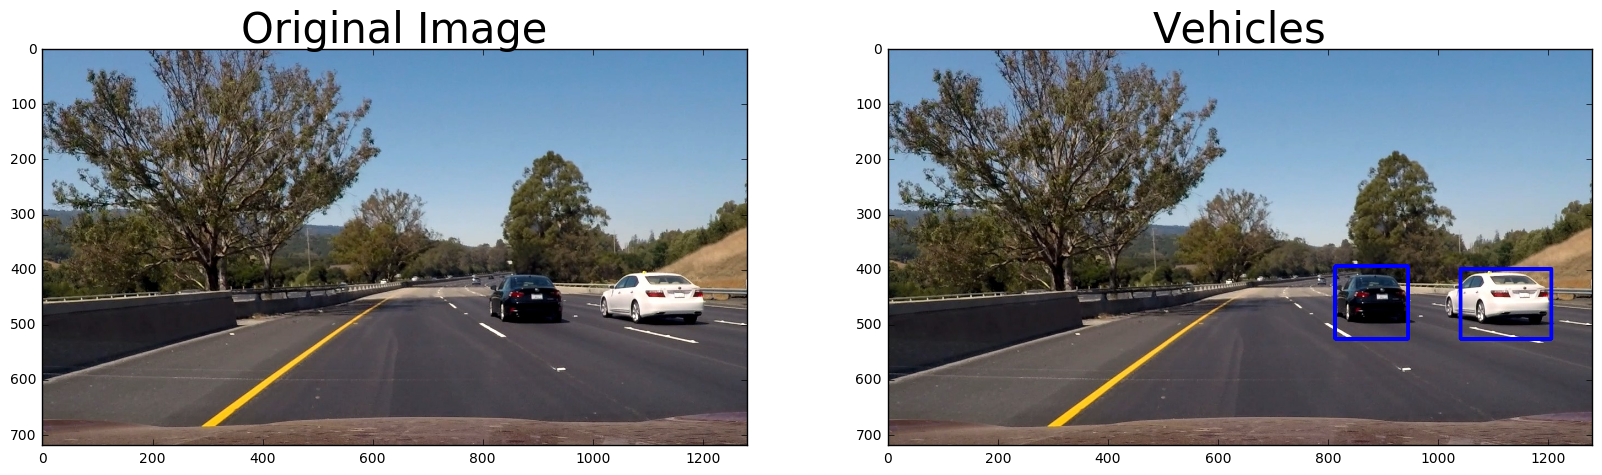

In [23]:
for image_path in all_test_images:
    test_img = mpimg.imread(image_path)
    res_img = image_pipeline(test_img, static_images=True)
    plot_image_set([test_img, res_img], titles=['Original Image', 'Vehicles'])

In [24]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [25]:
def process_image(image):
    result = image_pipeline(image)
    return result

In [ ]:
prev_frame_heat = None
output_clip = 'project_video_result2.mp4'
input_clip = VideoFileClip("project_video.mp4")
clip = input_clip.fl_image(process_image)
%time clip.write_videofile(output_clip, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_clip))